In [1]:
# -*- coding:utf-8 -*-
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
# conda install -c conda-forge spaghetti (if using conda)
import spaghetti
import os
import glob
from libpysal.weights import Queen
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx
from matplotlib import pyplot as plt
import matplotlib
from pyproj import Proj
import smopy
import seaborn as sns
import collections
import numpy as np
import math
from matplotlib import cm
import esda
from haversine import haversine
from splot.esda import lisa_cluster
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran
import statsmodels.api as sm
import warnings
import pysal as ps
from pysal.viz import mapclassify
import palettable as pltt
from seaborn import palplot
import zipfile
import folium  
from spreg import OLS
from spreg import ML_Error
from spreg import ML_Lag
import libpysal as lps
import matplotlib.pyplot as plt
import esda
import spreg
from sklearn.metrics import mean_squared_error as mse


# GWR prediction libraries
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
# from pysal.contrib.glm.family import Gaussian
from scipy.stats import pearsonr

warnings.filterwarnings("ignore")

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


建立读表函数

In [2]:
# read the file
def read_csv(data_file):
    df = pd.read_csv("./"+data_file)
    # df = adult_df.drop(columns='fnlwgt')
    return df

读取中国地图数据

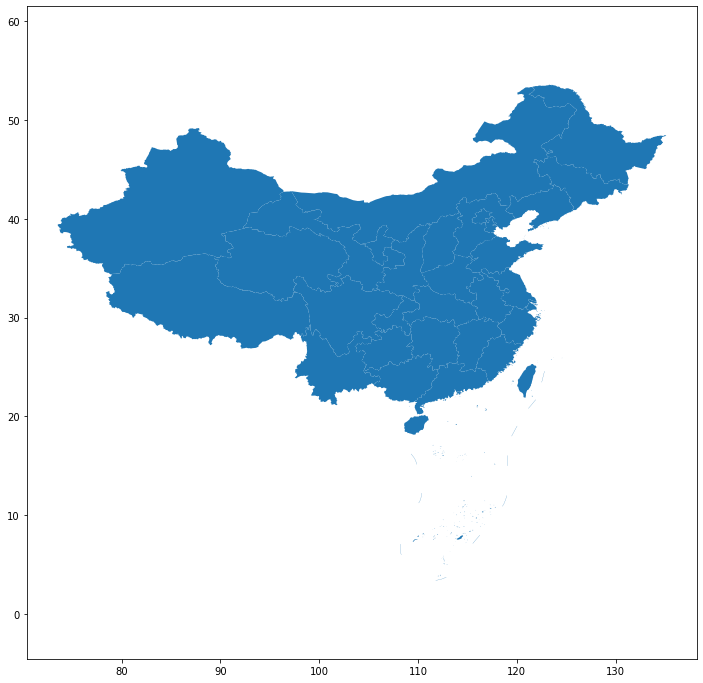

In [3]:
ch_map=gpd.read_file('./CH_MAP/China_map.shp')
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
ch_map.plot(ax=ax)  # you code here 
plt.axis('equal')
# Display
plt.show() 

In [4]:
# 修改中国地图的非必须项
ch_map = ch_map.drop(columns=['name', 'center','centroid','subFeature','acroutes','adchar','level','parent'])
ch_map = ch_map.dropna()
ch_map['adcode'] = ch_map['adcode'].astype(int)

读取中国2012-2021年各省份GDP数据

In [5]:
CH_GDP_df = read_csv('./Data/China_GDP_2012-2021.csv').dropna().reset_index(drop=True)

In [7]:
array1 = np.array(CH_GDP_df)  # 将df转换为list对象
list1 = array1.tolist()  # 将array转换为list
list1 = list1[0]         # 获取第一行的数据
list2 = [str(i) for i in list1]
print(list2)

['Region', '2021.0', '2020.0', '2019.0', '2018.0', '2017.0', '2016.0', '2015.0', '2014.0', '2013.0', '2012.0']


In [8]:
CH_GDP_df.columns = list2
CH_GDP_df = CH_GDP_df.drop(0).reset_index(drop=True)
CH_GDP_df

,Region,2021.0,2020.0,2019.0,2018.0,2017.0,2016.0,2015.0,2014.0,2013.0,2012.0
0,Beijing,40269.6,35943.3,35445.1,33106.0,29883.0,27041.2,24779.1,22926.0,21134.6,19024.7
1,Tianjin City,15695.0,14008.0,14055.5,13362.9,12450.6,11477.2,10879.5,10640.6,9945.4,9043.0
2,Hebei Province,40391.3,36013.8,34978.6,32494.6,30640.8,28474.1,26398.4,25208.9,24259.6,23077.5
3,Shanxi Province,22590.2,17835.6,16961.6,15958.1,14484.3,11946.4,11836.4,12094.7,11987.2,11683.1
4,Inner Mongolia Autonomous Region,20514.2,17258.0,17212.5,16140.8,14898.1,13789.3,12949.0,12158.2,11392.4,10470.1
5,Liaoning Province,27584.1,25011.4,24855.3,23510.5,21693.0,20392.5,20210.3,20025.7,19208.8,17848.6
6,Jilin Province,13235.5,12256.0,11726.8,11253.8,10922.0,10427.0,10018.0,9966.5,9427.9,8678.0
7,Heilongjiang Province,14879.2,13633.4,13544.4,12846.5,12313.0,11895.0,11690.0,12170.8,11849.1,11015.8
8,Shanghai,43214.9,38963.3,37987.6,36011.8,32925.0,29887.0,26887.0,25269.8,23204.1,21305.6
9,Jiangsu Province,116364.2,102807.7,98656.8,93207.6,85869.8,77350.9,71255.9,64830.5,59349.4,53701.9


In [53]:
value_list = []
label_list = []
color_list = ['red','blue','yellow','green','black','grey','purple','orange']

In [54]:
for i in range(CH_GDP_df.shape[0]):
    value_list.append(CH_GDP_df.iloc[i,1:11].values)
    label_list.append(CH_GDP_df.iloc[i,0])

x = CH_GDP_df.columns[1:11].values

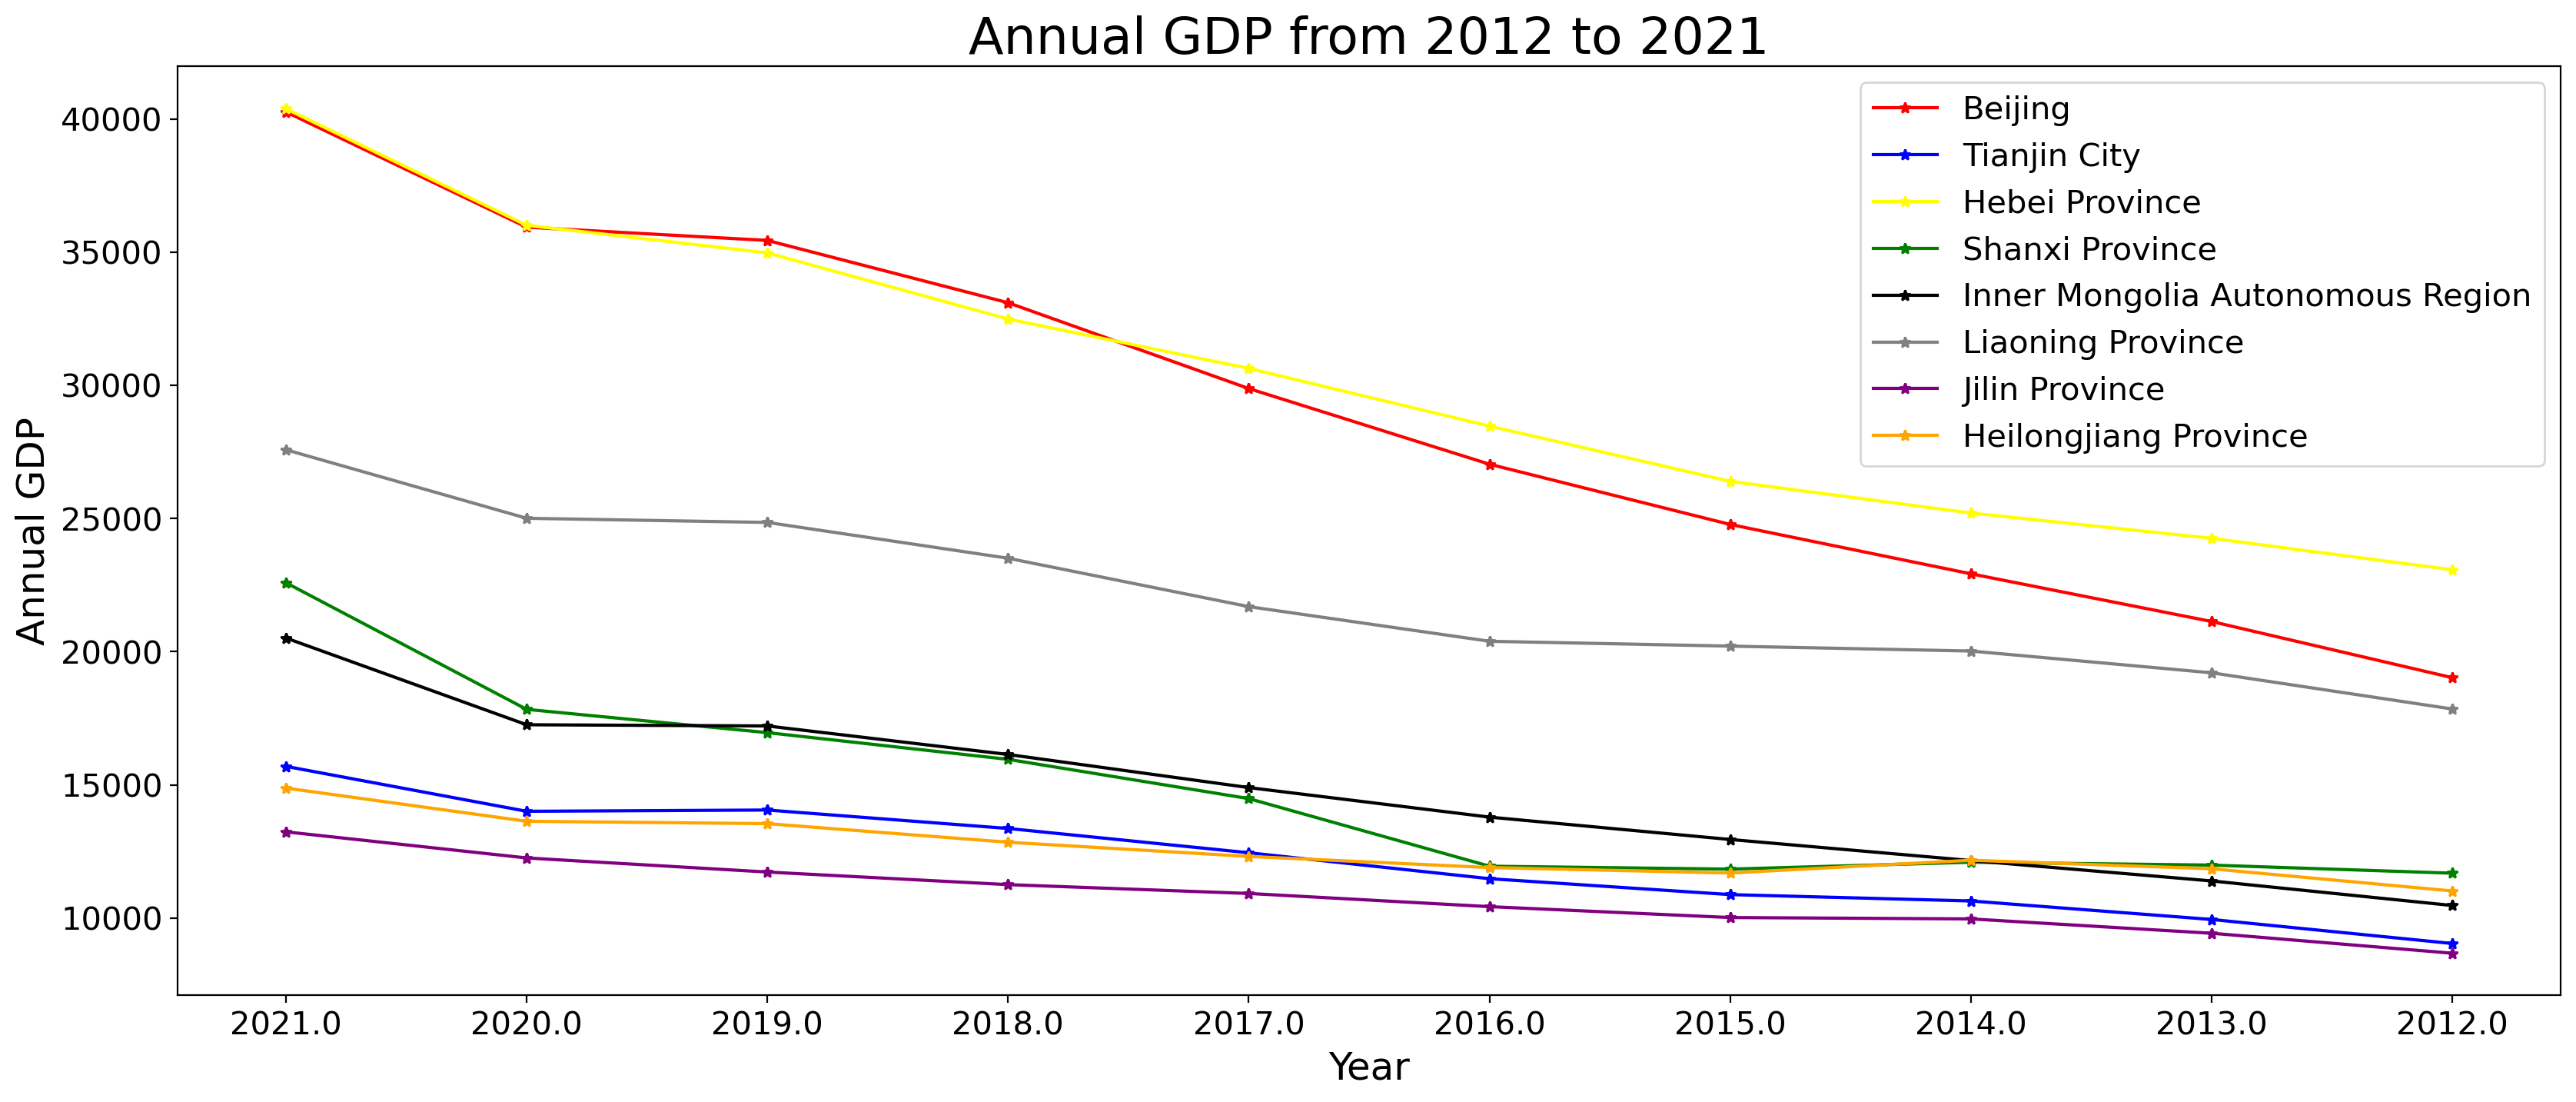

In [56]:
# 省份1-8
# Set the figuresize and dpi
plt.figure(figsize=(20, 8), dpi=200)
# Draw the bar
for i in range(0,8):
    plt.plot(x, value_list[i],color = color_list[i], marker='*', markersize=5, label= label_list[i])
plt.xticks(x, fontsize=15) 
plt.yticks(fontsize=15)
plt.title('Annual GDP from 2012 to 2021',fontsize=24)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Annual GDP',fontsize=18)
# # Show the value of each bar
plt.legend(label_list[0:8],fontsize=15)
plt.show()

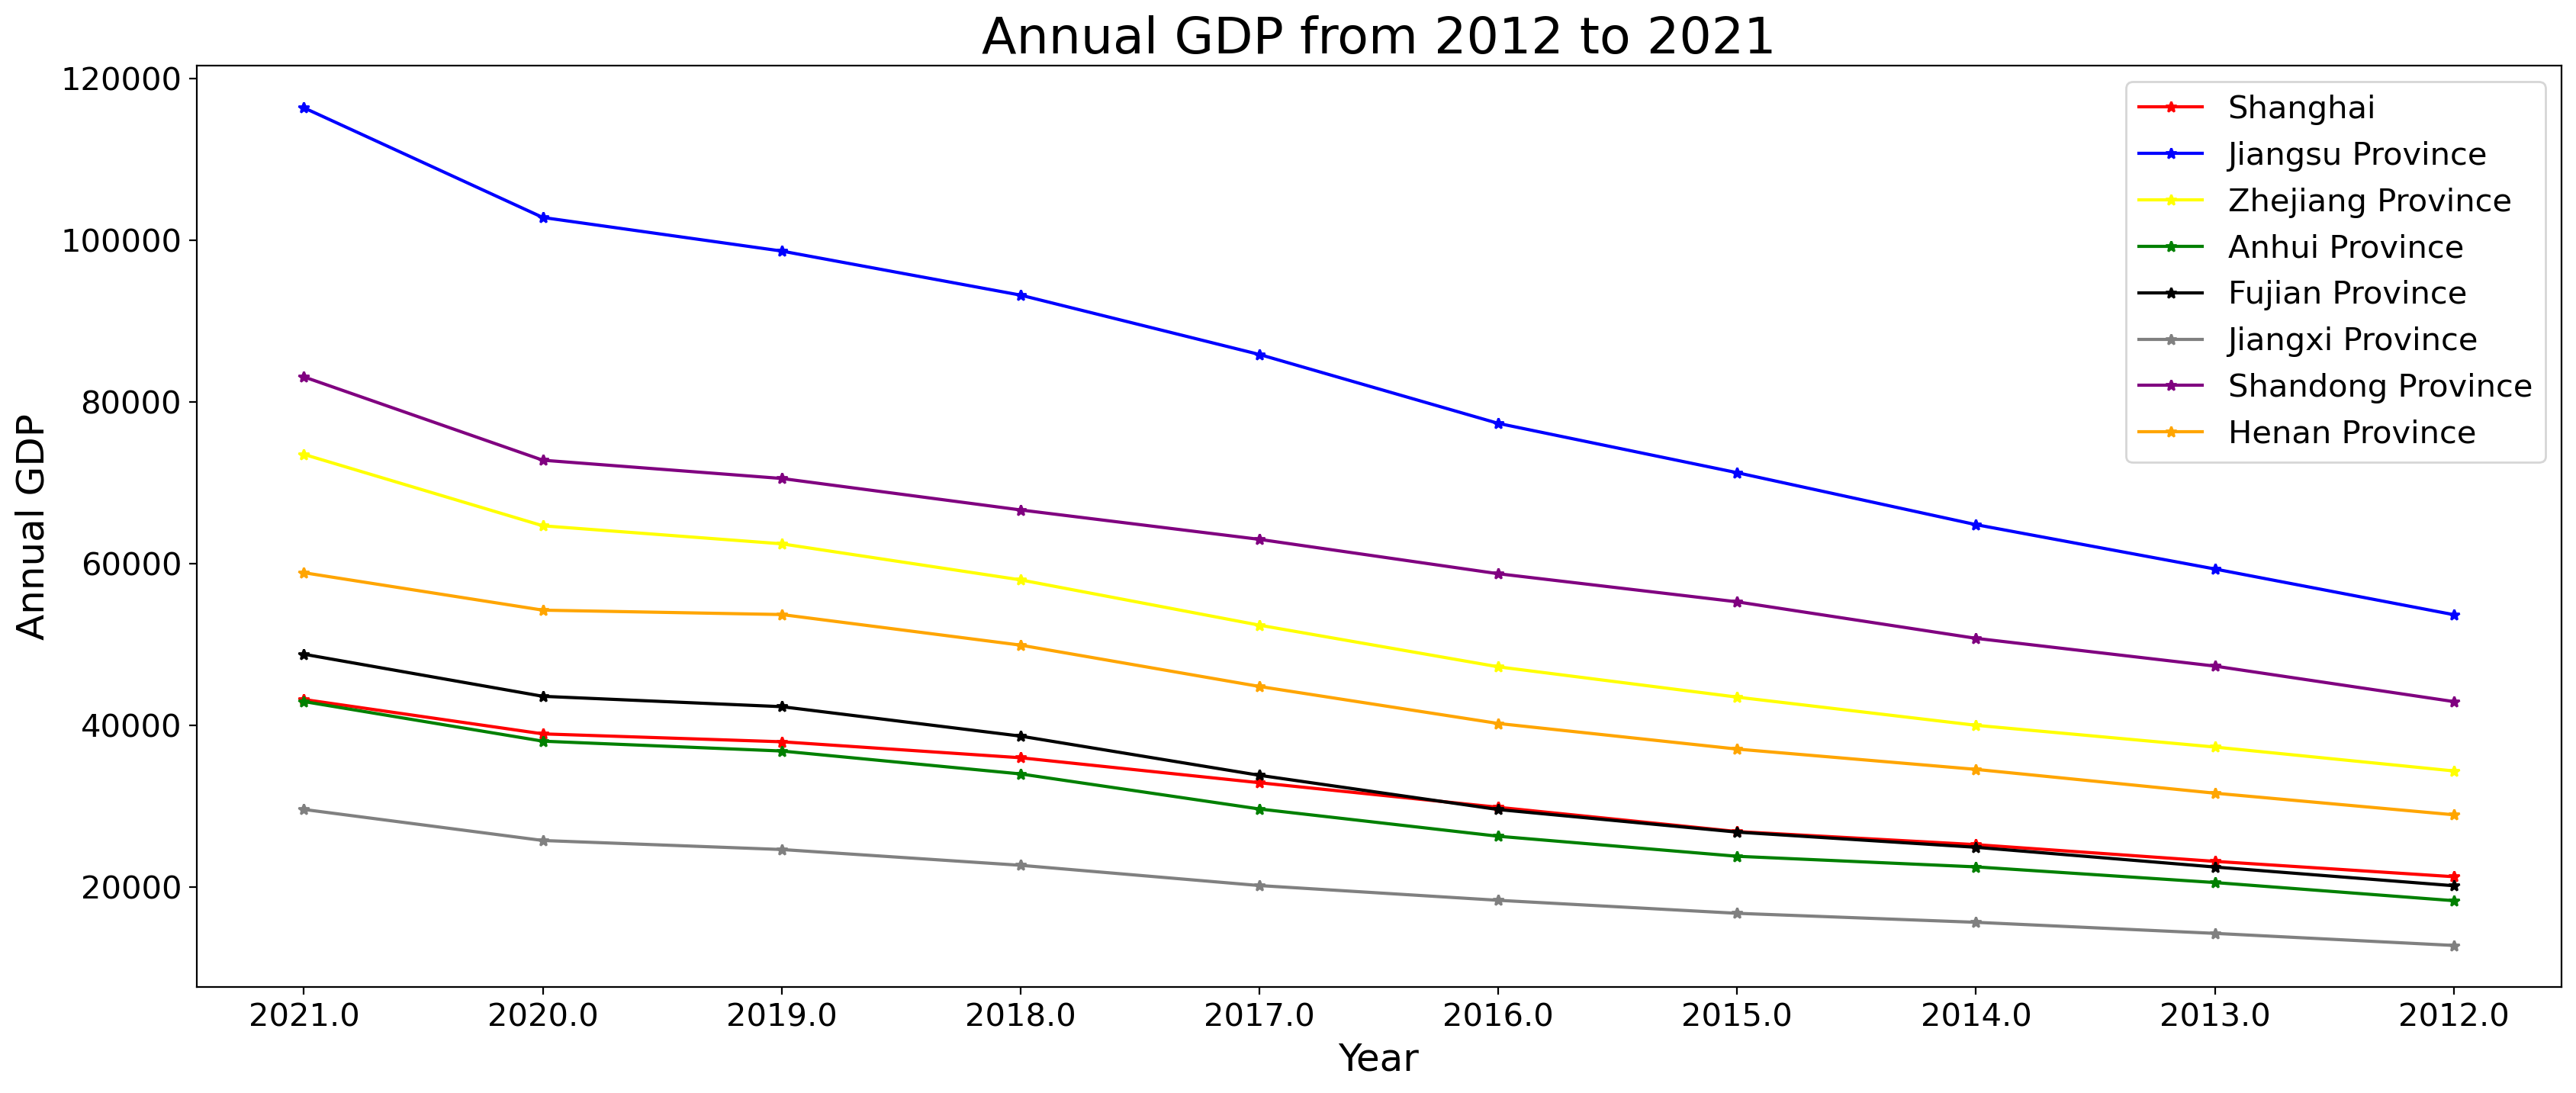

In [58]:
# 省份9-16
# Set the figuresize and dpi
plt.figure(figsize=(20, 8), dpi=200)
# Draw the bar
for i in range(8,16):
    plt.plot(x, value_list[i],color = color_list[i-8], marker='*', markersize=5, label= label_list[i])
plt.xticks(x, fontsize=15) 
plt.yticks(fontsize=15)
plt.title('Annual GDP from 2012 to 2021',fontsize=24)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Annual GDP',fontsize=18)
# # Show the value of each bar
plt.legend(label_list[8:16],fontsize=15)
plt.show()

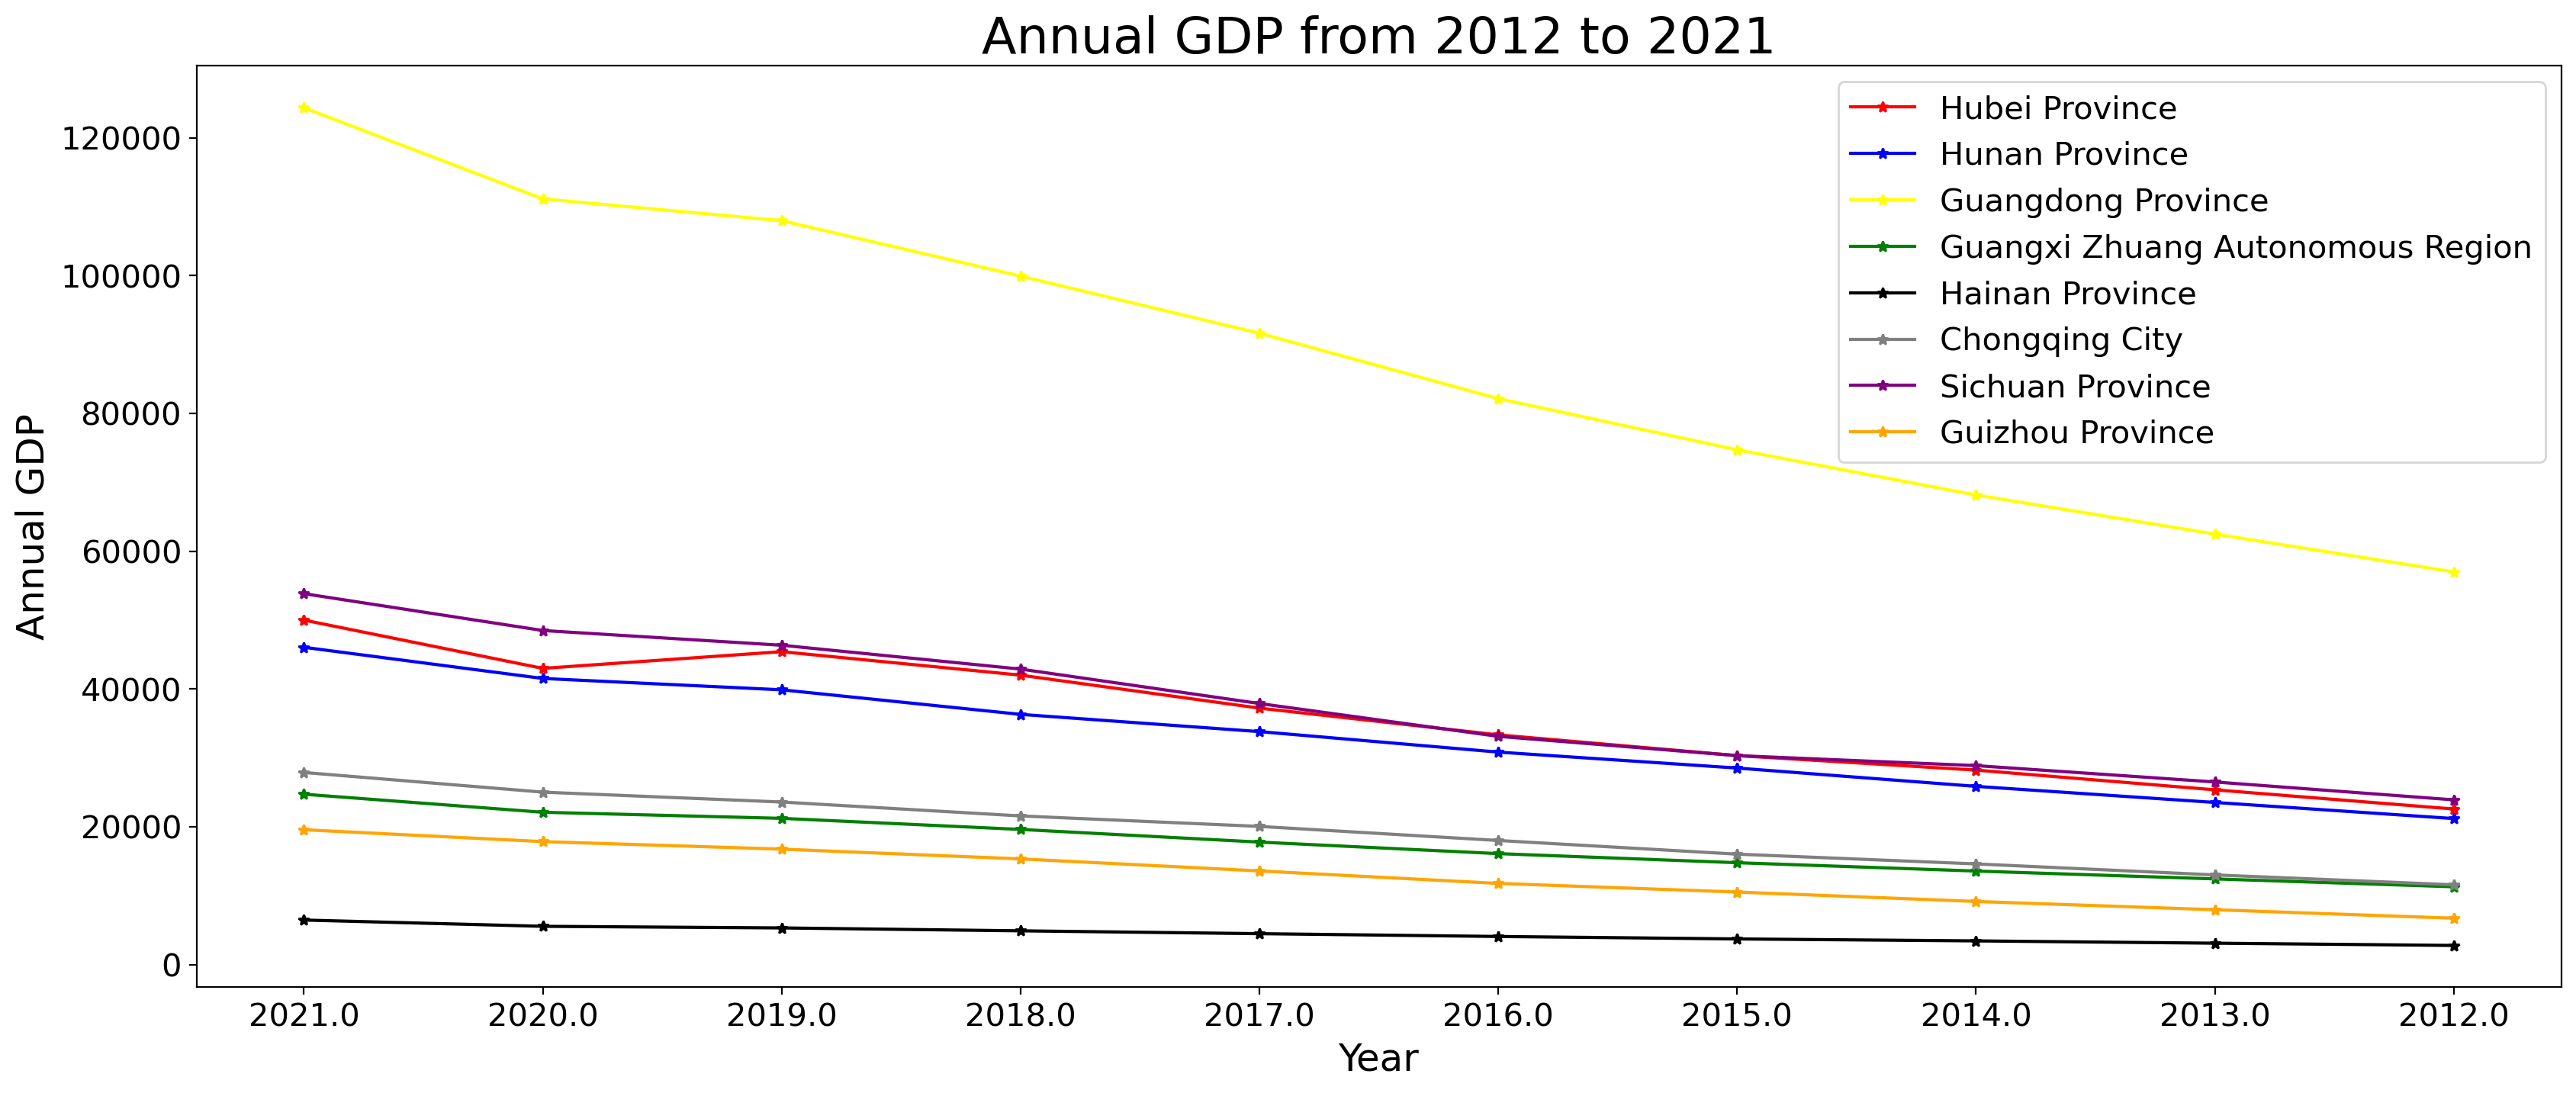

In [59]:
# 省份17-24
# Set the figuresize and dpi
plt.figure(figsize=(20, 8), dpi=200)
# Draw the bar
for i in range(16,24):
    plt.plot(x, value_list[i],color = color_list[i-16], marker='*', markersize=5, label= label_list[i])
plt.xticks(x, fontsize=15) 
plt.yticks(fontsize=15)
plt.title('Annual GDP from 2012 to 2021',fontsize=24)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Annual GDP',fontsize=18)
# # Show the value of each bar
plt.legend(label_list[16:24],fontsize=15)
plt.show()

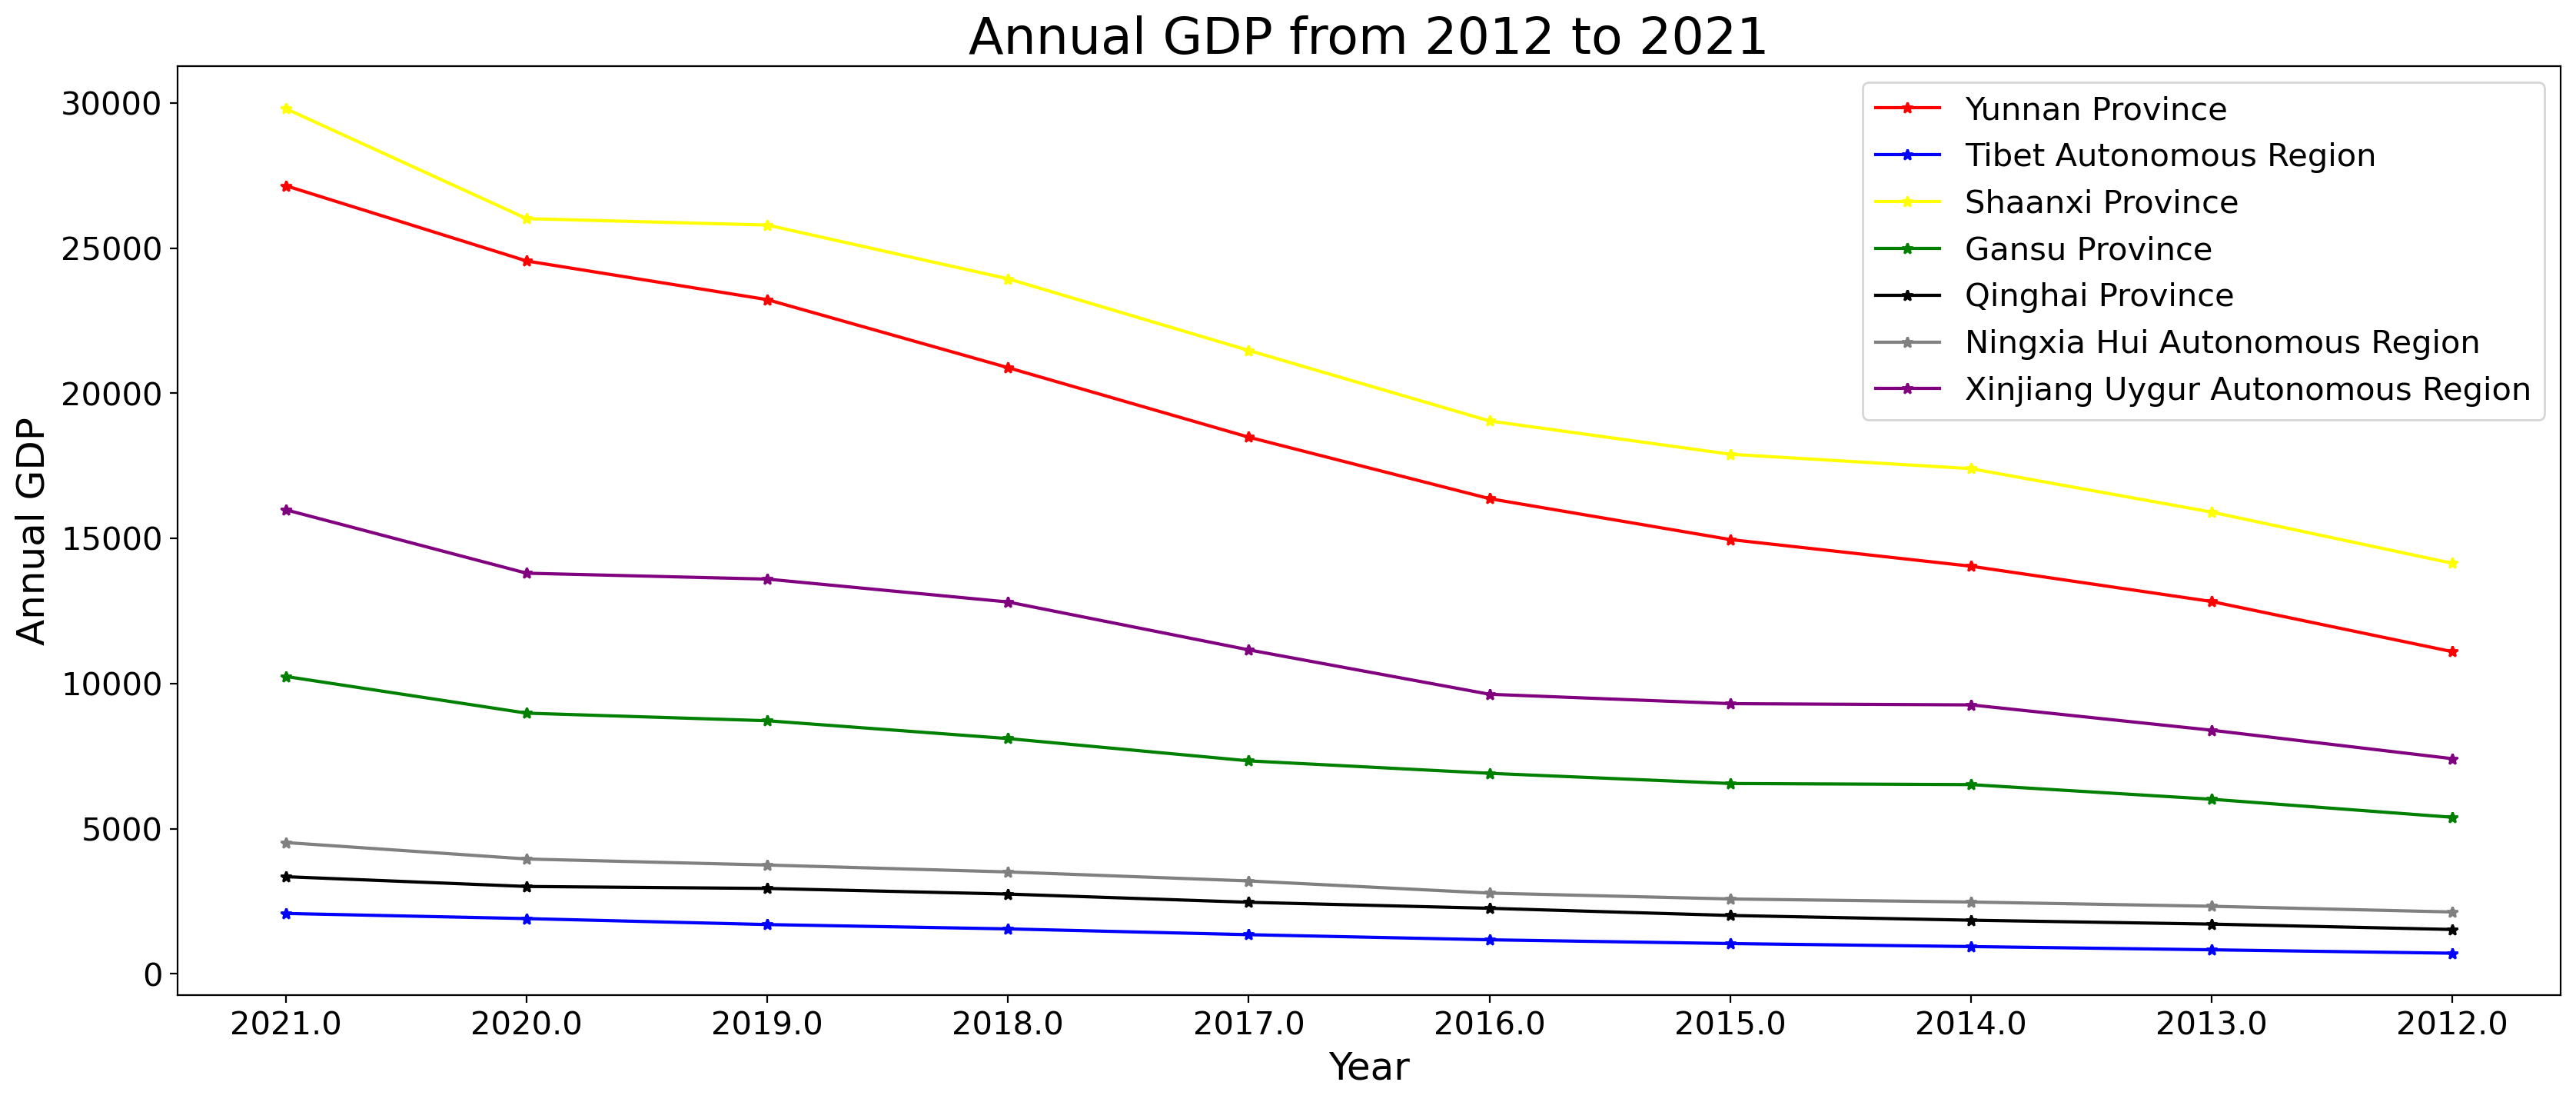

In [60]:
# 省份25-31
# Set the figuresize and dpi
plt.figure(figsize=(20, 8), dpi=200)
# Draw the bar
for i in range(24,31):
    plt.plot(x, value_list[i],color = color_list[i-24], marker='*', markersize=5, label= label_list[i])
plt.xticks(x, fontsize=15) 
plt.yticks(fontsize=15)
plt.title('Annual GDP from 2012 to 2021',fontsize=24)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Annual GDP',fontsize=18)
# # Show the value of each bar
plt.legend(label_list[24:31],fontsize=15)
plt.show()

读取2017-2021年中国各省份高考本科线平均分数数据

In [9]:
CH_EM_df = read_csv('./Data/China_EM_Data_2017-2021.csv').dropna().reset_index(drop=True)

In [10]:
CH_EM_df

,adcode,Region,2021,2020,2019,2018,2017
0,110000.0,Beijing,400.0,436.0,451.5,460.0,453.5
1,120000.0,Tianjin City,463.0,476.0,414.0,421.5,398.0
2,130000.0,Hebei Province,433.0,440.0,420.0,399.5,360.5
3,140000.0,Shanxi Province,434.0,459.0,456.5,454.0,426.0
4,150000.0,Inner Mongolia Autonomous Region,346.5,385.0,394.0,367.5,351.5
5,210000.0,Liaoning Province,396.0,415.5,425.5,414.5,389.0
6,220000.0,Jilin Province,320.0,353.5,361.0,418.5,395.5
7,230000.0,Heilongjiang Province,317.0,328.5,398.0,379.5,367.5
8,310000.0,Shanghai,400.0,400.0,403.0,401.0,402.0
9,320000.0,Jiangsu Province,446.5,298.5,292.0,283.0,275.0


In [11]:
merge_df = pd.merge(CH_EM_df, CH_GDP_df)
# Merge_df = pd.merge(merge_df, ch_map)

In [12]:
Merge_df = pd.merge(merge_df, ch_map)

In [13]:
Merge_df

,adcode,Region,2021,2020,2019,2018,2017,2021.0,2020.0,2019.0,2018.0,2017.0,2016.0,2015.0,2014.0,2013.0,2012.0,childrenNu,geometry
0,110000.0,Beijing,400.0,436.0,451.5,460.0,453.5,40269.6,35943.3,35445.1,33106.0,29883.0,27041.2,24779.1,22926.0,21134.6,19024.7,16.0,"POLYGON ((117.38988 40.22796, 117.38372 40.188..."
1,120000.0,Tianjin City,463.0,476.0,414.0,421.5,398.0,15695.0,14008.0,14055.5,13362.9,12450.6,11477.2,10879.5,10640.6,9945.4,9043.0,16.0,"MULTIPOLYGON (((117.76560 39.40053, 117.69970 ..."
2,130000.0,Hebei Province,433.0,440.0,420.0,399.5,360.5,40391.3,36013.8,34978.6,32494.6,30640.8,28474.1,26398.4,25208.9,24259.6,23077.5,11.0,"MULTIPOLYGON (((115.72253 39.54420, 115.72130 ..."
3,140000.0,Shanxi Province,434.0,459.0,456.5,454.0,426.0,22590.2,17835.6,16961.6,15958.1,14484.3,11946.4,11836.4,12094.7,11987.2,11683.1,11.0,"POLYGON ((110.37926 34.60061, 110.29549 34.610..."
4,150000.0,Inner Mongolia Autonomous Region,346.5,385.0,394.0,367.5,351.5,20514.2,17258.0,17212.5,16140.8,14898.1,13789.3,12949.0,12158.2,11392.4,10470.1,12.0,"POLYGON ((97.17290 42.79526, 97.28254 42.78208..."
5,210000.0,Liaoning Province,396.0,415.5,425.5,414.5,389.0,27584.1,25011.4,24855.3,23510.5,21693.0,20392.5,20210.3,20025.7,19208.8,17848.6,14.0,"MULTIPOLYGON (((119.85425 39.98857, 119.84563 ..."
6,220000.0,Jilin Province,320.0,353.5,361.0,418.5,395.5,13235.5,12256.0,11726.8,11253.8,10922.0,10427.0,10018.0,9966.5,9427.9,8678.0,9.0,"POLYGON ((125.70752 40.86688, 125.68781 40.897..."
7,230000.0,Heilongjiang Province,317.0,328.5,398.0,379.5,367.5,14879.2,13633.4,13544.4,12846.5,12313.0,11895.0,11690.0,12170.8,11849.1,11015.8,13.0,"POLYGON ((123.17848 46.24824, 123.14214 46.298..."
8,310000.0,Shanghai,400.0,400.0,403.0,401.0,402.0,43214.9,38963.3,37987.6,36011.8,32925.0,29887.0,26887.0,25269.8,23204.1,21305.6,16.0,"MULTIPOLYGON (((120.90135 31.01733, 120.89088 ..."
9,320000.0,Jiangsu Province,446.5,298.5,292.0,283.0,275.0,116364.2,102807.7,98656.8,93207.6,85869.8,77350.9,71255.9,64830.5,59349.4,53701.9,13.0,"POLYGON ((119.30607 35.07658, 119.29251 35.068..."


In [14]:
# Geographical coordinate conversion
crs = {'init': 'epsg:4326'}
ch_gdf = gpd.GeoDataFrame(Merge_df, crs=crs)
ch_gdf = ch_gdf.to_crs({'init': 'epsg:3857'})
ch_gdf.to_file(driver='ESRI Shapefile', filename='./CH_MAP/ch_gdf.shp')

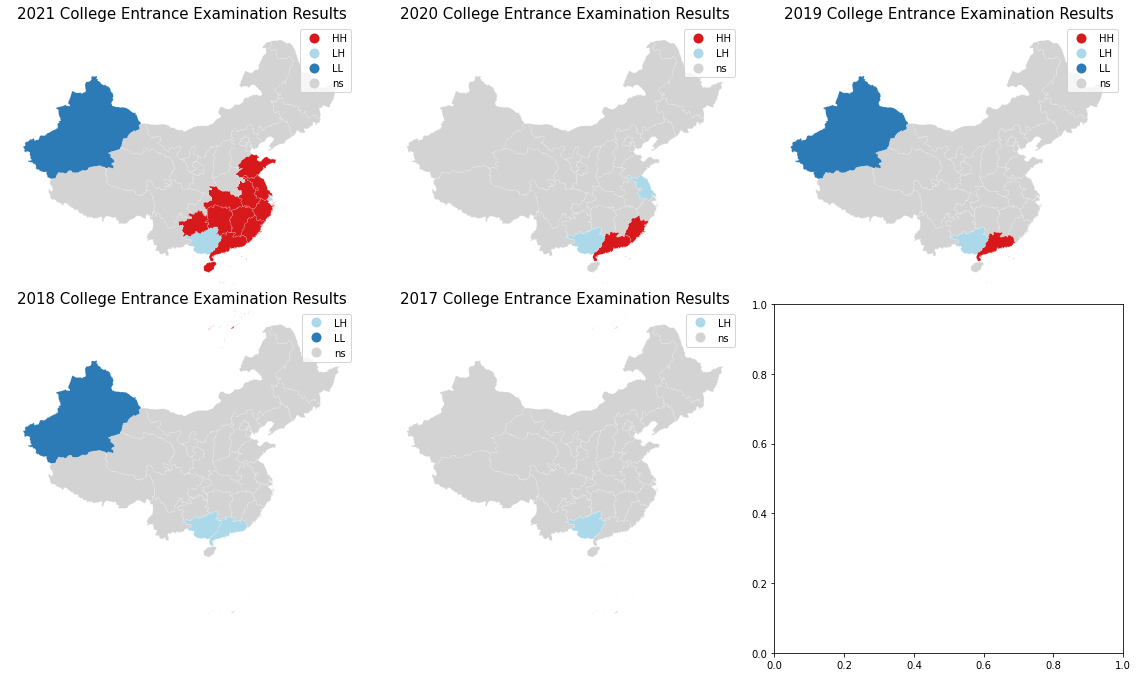

In [18]:
# 各年高考分数地区相关性分布图
y1 = ch_gdf['2021'].values
y2 = ch_gdf['2020'].values
y3 = ch_gdf['2019'].values
y4 = ch_gdf['2018'].values
y5 = ch_gdf['2017'].values


w = lps.weights.distance.Kernel.from_dataframe(ch_gdf, fixed=False, k=15)
w.transform = 'r'
lisa1 = esda.Moran_Local(y1, w)
lisa2 = esda.Moran_Local(y2, w)
lisa3 = esda.Moran_Local(y3, w)
lisa4 = esda.Moran_Local(y4, w)
lisa5 = esda.Moran_Local(y5, w)


fig,ax=plt.subplots(2,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = lisa_cluster(lisa1, ch_gdf, ax=ax[0][0])
ax[0][0].set_axis_off()
ax[0][0].set_title("2021 College Entrance Examination Results", size=15)

fig2 = lisa_cluster(lisa2, ch_gdf, ax=ax[0][1])
ax[0][1].set_axis_off()
ax[0][1].set_title("2020 College Entrance Examination Results", size=15)

fig3 = lisa_cluster(lisa3, ch_gdf, ax=ax[0][2])
ax[0][2].set_axis_off()
ax[0][2].set_title("2019 College Entrance Examination Results", size=15)

fig4 = lisa_cluster(lisa4, ch_gdf, ax=ax[1][0])
ax[1][0].set_axis_off()
ax[1][0].set_title("2018 College Entrance Examination Results", size=15)

fig5 = lisa_cluster(lisa5, ch_gdf, ax=ax[1][1])
ax[1][1].set_axis_off()
ax[1][1].set_title("2017 College Entrance Examination Results", size=15)


plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

In [19]:
imdfj = ps.viz.mapclassify.FisherJenks(ch_gdf['2021'], k=5)
imdfj

FisherJenks             

    Interval       Count
------------------------
[315.00, 346.50] |     6
(346.50, 400.00] |     7
(400.00, 434.00] |     5
(434.00, 452.00] |     7
(452.00, 495.00] |     6

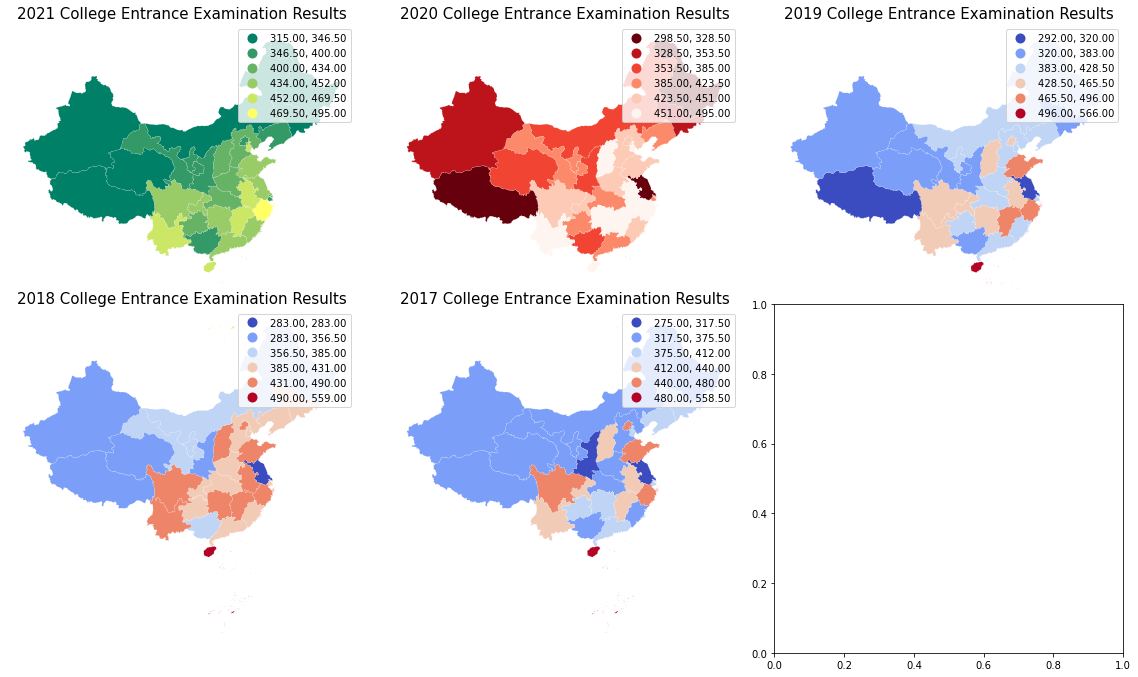

In [20]:
# 绘制每年各省份本科分数线分布图
fig,ax=plt.subplots(2,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = ch_gdf.plot(column='2021', scheme='FisherJenks', alpha=1, k=6, \
         cmap='summer', 
         edgecolor='w', linewidth=0.1,ax=ax[0][0], legend=True)
ax[0][0].set_axis_off()
ax[0][0].set_title("2021 College Entrance Examination Results", size=15)


fig2 = ch_gdf.plot(column='2020', scheme='FisherJenks', alpha=1, k=6, \
         cmap=plt.cm.Reds_r, 
         edgecolor='w', linewidth=0.1,ax=ax[0][1], legend=True)
ax[0][1].set_axis_off()
ax[0][1].set_title("2020 College Entrance Examination Results", size=15)

fig3 = ch_gdf.plot(column='2019', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[0][2], legend=True)
ax[0][2].set_axis_off()
ax[0][2].set_title("2019 College Entrance Examination Results", size=15)

fig4 = ch_gdf.plot(column='2018', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[1][0], legend=True)
ax[1][0].set_axis_off()
ax[1][0].set_title("2018 College Entrance Examination Results", size=15)

fig5 = ch_gdf.plot(column='2017', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[1][1], legend=True)
ax[1][1].set_axis_off()
ax[1][1].set_title("2017 College Entrance Examination Results", size=15)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

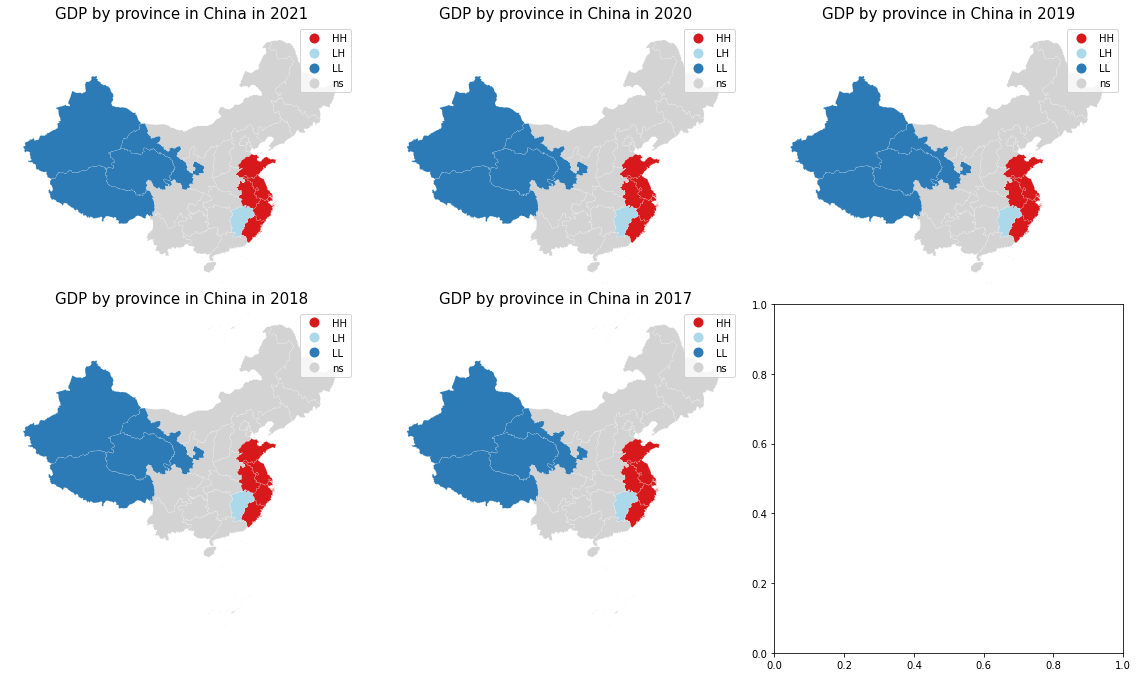

In [21]:
# 各年高考分数地区相关性分布图
y11 = ch_gdf['2021.0'].values
y22 = ch_gdf['2020.0'].values
y33 = ch_gdf['2019.0'].values
y44 = ch_gdf['2018.0'].values
y55 = ch_gdf['2017.0'].values


w = lps.weights.distance.Kernel.from_dataframe(ch_gdf, fixed=False, k=15)
w.transform = 'r'
lisa11 = esda.Moran_Local(y11, w)
lisa22 = esda.Moran_Local(y22, w)
lisa33 = esda.Moran_Local(y33, w)
lisa44 = esda.Moran_Local(y44, w)
lisa55 = esda.Moran_Local(y55, w)


fig,ax=plt.subplots(2,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = lisa_cluster(lisa11, ch_gdf, ax=ax[0][0])
ax[0][0].set_axis_off()
ax[0][0].set_title("GDP by province in China in 2021", size=15)

fig2 = lisa_cluster(lisa22, ch_gdf, ax=ax[0][1])
ax[0][1].set_axis_off()
ax[0][1].set_title("GDP by province in China in 2020", size=15)

fig3 = lisa_cluster(lisa33, ch_gdf, ax=ax[0][2])
ax[0][2].set_axis_off()
ax[0][2].set_title("GDP by province in China in 2019", size=15)

fig4 = lisa_cluster(lisa44, ch_gdf, ax=ax[1][0])
ax[1][0].set_axis_off()
ax[1][0].set_title("GDP by province in China in 2018", size=15)

fig5 = lisa_cluster(lisa55, ch_gdf, ax=ax[1][1])
ax[1][1].set_axis_off()
ax[1][1].set_title("GDP by province in China in 2017", size=15)



plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()

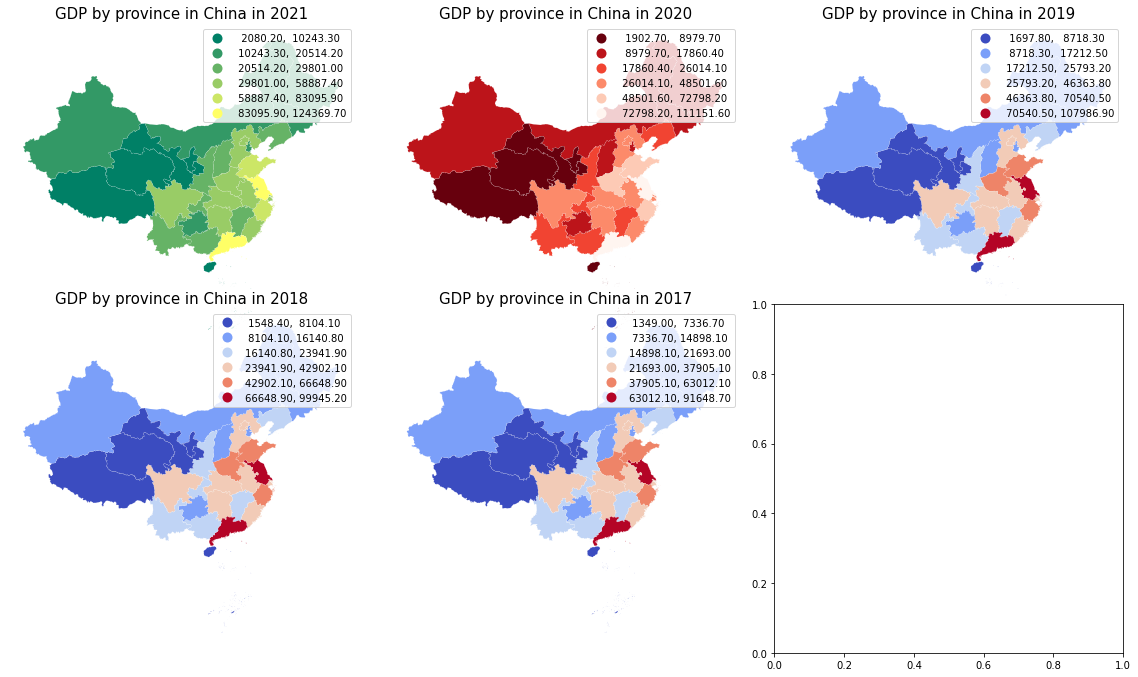

In [22]:
# 绘制每年各省份本科分数线分布图
fig,ax=plt.subplots(2,3,figsize=(20,12), subplot_kw=dict(aspect='equal'))
# cited from Week7 codes in Spatial Data Analysis(7CUSMSDA)
fig1 = ch_gdf.plot(column='2021.0', scheme='FisherJenks', alpha=1, k=6, \
         cmap='summer', 
         edgecolor='w', linewidth=0.1,ax=ax[0][0], legend=True)
ax[0][0].set_axis_off()
ax[0][0].set_title("GDP by province in China in 2021", size=15)


fig2 = ch_gdf.plot(column='2020.0', scheme='FisherJenks', alpha=1, k=6, \
         cmap=plt.cm.Reds_r, 
         edgecolor='w', linewidth=0.1,ax=ax[0][1], legend=True)
ax[0][1].set_axis_off()
ax[0][1].set_title("GDP by province in China in 2020", size=15)

fig3 = ch_gdf.plot(column='2019.0', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[0][2], legend=True)
ax[0][2].set_axis_off()
ax[0][2].set_title("GDP by province in China in 2019", size=15)

fig4 = ch_gdf.plot(column='2018.0', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[1][0], legend=True)
ax[1][0].set_axis_off()
ax[1][0].set_title("GDP by province in China in 2018", size=15)

fig5 = ch_gdf.plot(column='2017.0', scheme='FisherJenks', alpha=1, k=6, \
         cmap='coolwarm', 
         edgecolor='w', linewidth=0.1,ax=ax[1][1], legend=True)
ax[1][1].set_axis_off()
ax[1][1].set_title("GDP by province in China in 2017", size=15)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=-0.3)
plt.show()